<h2> Generating Faces With A WGan </h2>

In [1]:
import torch
import torchvision
import os
import PIL
import pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
def show(tensor,num=25,name=''):
    data=tensor.detach().cpu()
    grid=make_grid(data[:num],nrow=5).permute(1,2,0)
    plt.imshow(grid.clip(0,1))
    plt.show
    

In [51]:
##hyperparameters and general parameters
n_epochs=10000
batch_size=128
lr=1e-4
z_dim=200
device='cuda'

cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=35
save_step=35



In [57]:
#Generator model
#n=>Input image width/height (or feature map channels for later layers)
#stride=> Stride of the kernel in the convolutional layer
#padding=>Padding applied to the input borders in the convolutional layer (e.g., 'same' or 'valid')
#ks=> Kernel size: Size of the convolutional kernel (filter)
#nn.ConvTranspose2d :(n-1)*stride-2*padding+ks
#nn.Conv2d : (n+2*pad-ks)//stride+1
class Generator(nn.Module):
    def __init__(self,z_dim=64,d_dim=16):
        super (Generator,self).__init__()
        self.z_dim=z_dim
        #we begin with a 1x1 image with z_dim number of channels (200)
        self.gen=nn.Sequential(
            nn.ConvTranspose2d(z_dim,d_dim*32,kernel_size=4,stride=1,padding=0), #(((1-1)*1)-2*0)+4=4 so size 4x4 and (ch=200(z_dim),512(d_dim*32))
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(d_dim*32,d_dim*16,kernel_size=4,stride=2,padding=1),#(((4-1)*2)-2*1)+4=8 so size 8x8 and (ch=512(d_dim*32),256(d_dim*16))
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(d_dim*8,d_dim*4,kernel_size=4,stride=2,padding=1),#(((16-1)*2)-2*1)+4=32 so size 32x32 and (ch=128(d_dim*8),64(d_dim*4))
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*4,d_dim*2,kernel_size=4,stride=2,padding=1),#(((32-1)*2)-2*1)+4=64 so size 64x64 and (ch=64(d_dim*4),32(d_dim*2))
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*2,3,kernel_size=4,stride=2,padding=1),#(((64-1)*2)-2*1)+4=128 so size 128x128 and (ch=32(d_dim*2),3)
            nn.Tanh() #Produce result in the range from -1 to 1
                       
        )


    def forward(self,noise):
        x=noise.view(len(noise),self.z_dim,1,1) #128x200x1x1
        return self.gen(x)



def gen_noise(num,z_dim,device='cuda'):
    return torch.randn(num,z_dim,device=device)#128x200
    
    

In [58]:
#Critic model
#conv2d: in_channels, out_channels,kernel_size,stride=1,padding=0
#new width and height: #(n+2*pad-ks)//stride+1
class Critic(nn.Module):
    def __init__(self,d_dim=16):
        super(Critic,self).__init__()
        self.crit=nn.Sequential(
        #conv2d: in_channels, out_channels,kernel_size,stride=1,padding=0
        #new width and height: #(n+2*pad-ks)//stride+1
        nn.Conv2d(3,d_dim,kernel_size=4,stride=2,padding=1), #(128+2*1-4)//2+1=64 so new size 64x64 and ch:(3,16(d_dim))
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim,d_dim*2,kernel_size=4,stride=2,padding=1), #(64+2*1-4)//2+1=32 so new size 32x32 and ch:(16(d_dim),32(d_dim*2))
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2,d_dim*4,kernel_size=4,stride=2,padding=1), #(32+2*1-4)//2+1=16 so new size 16x16 and ch:(32(d_dim*2),64(d_dim*4))
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4,d_dim*8,kernel_size=4,stride=2,padding=1), #(16+2*1-4)//2+1=8 so new size 8x8 and ch:(64(d_dim*4),128(d_dim*8))
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(d_dim*8,d_dim*16,kernel_size=4,stride=2,padding=1), #(8+2*1-4)//2+1=4 so new size 4x4 and ch:(128(d_dim*8),256(d_dim*16))
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16,1,kernel_size=4,stride=1,padding=0), #(4+2*1-4)//2+0=1 so new size 1x1 and ch:(256(d_dim*16),1)
       )
    def forward(self,image):
       #image:128x3x128x128
        crit_pred=self.crit(image) #128x1x1x1   batch size x channel x widht x height
        return crit_pred.view(len(crit_pred),-1) #128x1

In [ ]:
#load dataset
"""
import gdown, zipfile

url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
path='data/celeba'
download_path=f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)
"""

#or you can download manuel from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ

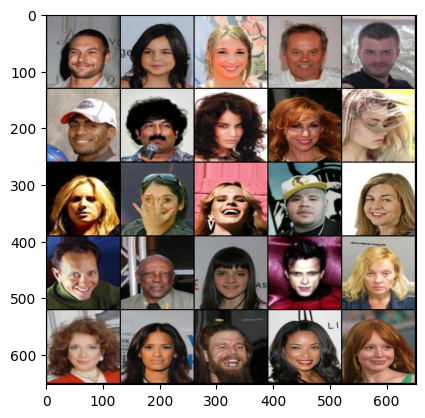

In [60]:
class Dataset(Dataset):
    def __init__(self,path,size=128,lim=10000):
        self.sizes=[size,size]
        items,labels=[],[]
        for data in os.listdir(path)[:lim]:
            #path:'./data/celaba/img_align_celaba'
            #data:'114568.jpg'
            item=os.path.join(path,data)
            items.append(item)
            labels.append(data)
        self.items=items
        self.labels=labels

    def __len__(self):
        return len(self.items)
        
    def __getitem__(self,idx):
        data=PIL.Image.open(self.items[idx]).convert('RGB') #(178,218)
        data=np.asarray(torchvision.transforms.Resize(self.sizes)(data))#128x128x3
        data=np.transpose(data,(2,0,1)).astype(np.float32, copy=False) #3 x128 x 128
        data=torch.from_numpy(data).div(255)
        return data,self.labels[idx]

path=os.getcwd()
data_path=path+"/data/celaba/img_align_celeba"

ds= Dataset(data_path,size=128,lim=10000)
##DataLoader
dataloader=DataLoader(ds,batch_size=batch_size,shuffle=True)

##Models

gen=Generator(z_dim).to(device)
crit=Critic().to(device)

##optimizers

gen_opt=torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.9))
crit_opt=torch.optim.Adam(crit.parameters(),lr=lr,betas=(0.5,0.9))
x,y=next(iter(dataloader))
show(x)

In [61]:
##gradient penalty calculation

def get_gp(real,fake,crit,alpha,gamma=10):
    mix_images = real*alpha+fake*(1-alpha) #128 x 3 x 128 x 128
    mix_scores = crit(mix_images) #128 x 1

    gradient=torch.autograd.grad(
        inputs=mix_images,
        outputs = mix_scores,grad_outputs =torch.ones_like(mix_scores),
        retain_graph=True,
        create_graph=True
    )[0] #128 x 3 x 128 x 128
    
    gradient=gradient.view(len(gradient),-1) #128 x 49152
    gradient_norm=gradient.norm(2)
    gp=gamma*((gradient_norm-1)**2).mean()

    return gp

In [70]:
#save and load checkpoitns
root_path="./data/"

def save_checkpoint(name):
    torch.save({
        'epoch':epoch,
        'model_state_dict': gen.state_dict(),
        'optimizer_state_dict':gen_opt.state_dict()
    },f"G-{name}.pkl")
    torch.save({
        'epoch':epoch,
        'model_state_dict': crit.state_dict(),
        'optimizer_state_dict':crit_opt.state_dict()
    },f"C-{name}.pkl")
    print("Saved Checkpoint")


def load_checkpoint(name):
    checkpoint=torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint=torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded Checkpoint")


In [71]:
epoch=1
save_checkpoint("test")

Saved Checkpoint
